** Notes **
* Be very careful when constructing the resolution matrix. If missed by a transpose, the result will be wrong!!

In [1]:
# %cd ~/dev/graphite-DOS/irradiated-notebooks/

In [1]:
from __future__ import (absolute_import, division, print_function)

import os, sys
import numpy as np
from matplotlib import pyplot as plt
import numpy as np, histogram.hdf as hh, histogram as H
from scipy.interpolate import interp1d
import warnings
from numpy import linalg as LA

In [2]:
# %matplotlib notebook
%matplotlib inline

In [3]:
sys.path.insert(0, '/home/fi0/dev/sandbox/SR-INS/1D/dev/srins/')
sys.path.append('/home/fi0/dev/sandbox/SR-INS/srins/Jiao_Res/graphite-DOS/dgsres')

In [4]:
import srins

In [5]:
import srins.powder.linearizedBregman as splb; reload(splb)
import srins.powder.conv_deconv as spcd
import srins.powder.Lucy_Richardson as LR; reload(LR)
import srins.powder.bregmanSplit as spbs; reload(spbs)

<module 'srins.powder.bregmanSplit' from '/home/fi0/dev/sandbox/SR-INS/1D/dev/srins/srins/powder/bregmanSplit.pyc'>

In [6]:
from srins.powder.conv_deconv import convolve_NS as F

In [7]:
# for test data
EaxisT=np.arange(-20, 100, 0.1)
NT=EaxisT.size
print (NT)


1200


In [8]:
20/0.1

200.0

In [9]:
print (EaxisT)

[-20.  -19.9 -19.8 ...,  99.7  99.8  99.9]


In [10]:
def gauss(x, center, ht, sigma):
    return ht * np.exp(-(x-center)**2/2/sigma**2)

# creating of nonRealresolution

* The varied widths of the resolution functions

In [11]:
# width=np.arange(0.3, 1.9, 0.3)
# Nw=width.size
# print (Nw)
# print (width)

In [12]:
# # test resolution created
# res1 = np.zeros((NT, NT))
# res2=np.zeros((NT, NT))
# # res2SameASres1=np.zeros((Nw, NT, NT))
# print (res1.shape)

In [13]:
# print (res1[1][1].shape)

# Energy dependent Gaussian Resolution 

In [14]:
N=np.arange(1,NT+1,1)

In [15]:
# for i in range(int (NT)):
#         res1[i]= gauss(EaxisT, EaxisT[i], 1., N[i]/150 )

In [16]:
400/150

2.6666666666666665

# Energy dependent Assymtrical Resolution 

In [17]:
def twogauss(x, center, ht, sigma_left, sigma_right):
    lcenter = -sigma_left*np.sqrt(2/np.pi)
    rcenter = sigma_right*np.sqrt(2/np.pi)
    center1 = (lcenter*sigma_left + rcenter*sigma_right) / (sigma_left+sigma_right)
    center -= center1
    y = gauss(x, center, ht, sigma_left)
    y[x>center] = gauss(x[x>center], center, ht, sigma_right)
    y/=y.sum()
    return y

In [18]:
spacing=0.1
negativeE=20
negativeIndex=negativeE/spacing
print (negativeIndex)

200.0


In [19]:
def FWHM(Y,X):
    d = Y - (max(Y) / 2)
    indexes = np.where(d > 0)[0]
    return abs(X[indexes[-1]] - X[indexes[0]])

In [20]:
EaxisT

array([-20. , -19.9, -19.8, ...,  99.7,  99.8,  99.9])

In [21]:
EaxisTc=EaxisT.copy()
res3=np.zeros((NT, NT))
res2=np.zeros((NT, NT))
res1 = np.zeros((NT, NT))
av=np.zeros(NT)
sigma=np.zeros(NT)
for i in range(int (NT)):
    EaxisTc[i]=negativeIndex+EaxisTc[i]
#     print (EaxisTc[i]/80)
#     print (N[i]/150)
#     res1[i]= gauss(EaxisT, EaxisT[i], 1., N[i]/150 )
    res2[i]= twogauss(EaxisT, EaxisT[i], 1., EaxisTc[i]/80, 80/EaxisTc[i] )
    res3[i]= twogauss(EaxisT, EaxisT[i], 1., 80/EaxisTc[i], EaxisTc[i]/80 )
    av[i]=np.sum(res2[i]*EaxisT)
    sigma[i]=np.sqrt(np.sum(res2[i]*(EaxisT-av[i])**2))
    res1[i]= gauss(EaxisT, EaxisT[i], 1., sigma[i] )
    res1[i]/=res1[i].sum()

In [22]:
EaxisTc[400]/80

2.7500000000000071

In [23]:
80/EaxisTc[400], 40/EaxisTc[400]

(0.3636363636363627, 0.18181818181818135)

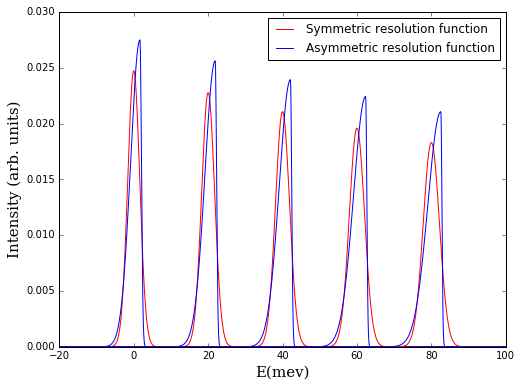

In [36]:
s=15
plt.figure(figsize=(8,6))
# plt.plot(EaxisT, res1[1])
plt.plot(EaxisT, res1[200], color='r', label='Symmetric resolution function')
plt.plot(EaxisT, res2[200], color='b', label='Asymmetric resolution function')
plt.plot(EaxisT, res1[400], color='r')
plt.plot(EaxisT, res2[400], color='b')
plt.plot(EaxisT, res1[600], color='r')
plt.plot(EaxisT, res2[600], color='b')
plt.plot(EaxisT, res1[800], color='r')
plt.plot(EaxisT, res2[800], color='b')
plt.plot(EaxisT, res1[1000], color='r')
plt.plot(EaxisT, res2[1000], color='b')
plt.xlabel('E(mev)',fontsize=s, family='serif')
plt.ylabel('Intensity (arb. units)',fontsize=s, family='serif')
plt.legend()
# plt.plot(EaxisT, res1[300])
# plt.plot(EaxisT, res1[400])
# plt.plot(EaxisT, res3[400])
# plt.plot(EaxisT, res1[400])
# plt.plot(EaxisT, res3[40])
# plt.plot(EaxisT, res1[600])
# plt.plot(EaxisT, res1[800])
# plt.plot(EaxisT, res1[800])
# plt.plot(EaxisT, res1[1100])
# plt.show()
plt.savefig('SymAndNon-symResolutionFunc.eps',  dpi=1000)

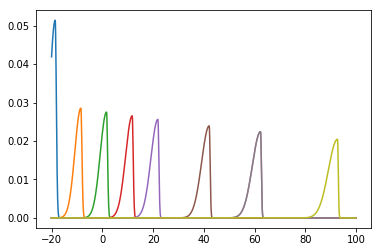

In [105]:
plt.figure()
plt.plot(EaxisT, res2[0])
plt.plot(EaxisT, res2[100])
plt.plot(EaxisT, res2[200])
plt.plot(EaxisT, res2[300])
plt.plot(EaxisT, res2[400])
plt.plot(EaxisT, res2[600])
plt.plot(EaxisT, res2[800])
plt.plot(EaxisT, res2[800])
plt.plot(EaxisT, res2[1100])
plt.show()

## non noisy data creation

* The widths of the original peaks
* The distance between the original peaks

In [106]:
400/150

2.6666666666666665

In [107]:
def normgauss(x, center, ht, sigma):
    return(gauss(x, center, ht, sigma)/gauss(x, center, ht, sigma).sum())

<function matplotlib.pyplot.show>

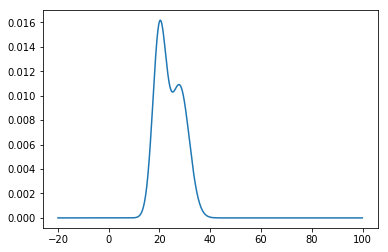

In [108]:
y1= normgauss(EaxisT, 20, 1, 2.66)+normgauss(EaxisT, 20+8, 1, 2.66*1.4)
plt.figure()
plt.plot(EaxisT,y1, label='closer peaks')
plt.show

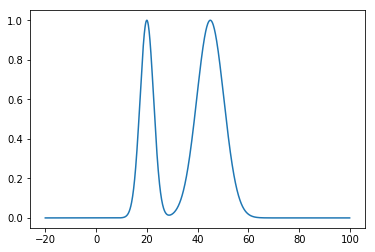

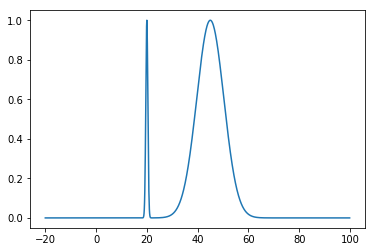

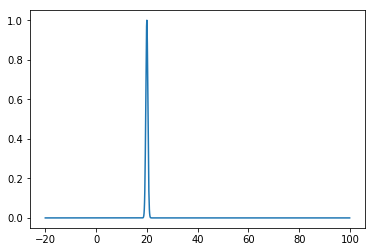

sigma 1.7519551180447759
sigma 1.8931515917104478
sigma 2.036135286929596
sigma 2.1804450162683344


<function matplotlib.pyplot.show>

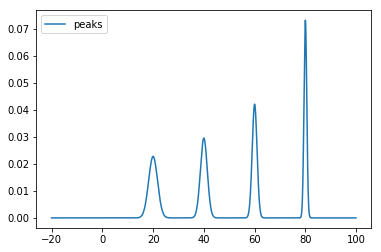

In [109]:
# five peaks with different width--ist (same as symmetric,),peaks will be narrower,  last (half of the sigma of the sharper edge), 
# data dependency of the algorithm
y2= gauss(EaxisT, 20, 1, 2.66)+gauss(EaxisT, 20+25, 1, 2.66*2)
plt.figure()
plt.plot(EaxisT,y2, label='closer peaks')
plt.show

y2= gauss(EaxisT, 20, 1, 0.4)+gauss(EaxisT, 20+25, 1, 2.66*2)
plt.figure()
plt.plot(EaxisT,y2, label='closer peaks')
plt.show

plt.figure()
y2= gauss(EaxisT, 20, 1, 0.4)
plt.plot(EaxisT,y2, label='closer peaks')
plt.show()

ini=20
step=20
num=4
plt.figure('diff')
y2=0
y2_a=0
fstIn=int ((negativeE+ini+(step*0))/spacing)
lstIn=int ((negativeE+ini+(step*(num-1)))/spacing)
sigmaN=np.linspace(sigma[fstIn],40/EaxisTc[lstIn], num+1 )
for i in xrange(num):
    Energy=ini+(step*i)
    index= int ((negativeE+ini+(step*i))/spacing)
    
    sigmaAR=40/EaxisTc[index]
    
#     y2 += gauss(EaxisT, ini+(step*0), 1, 0.4)+gauss(EaxisT, ini+(step*0), 1, 2.66*2)+gauss(EaxisT, ini+(step*0), 1, 2.66*2)+gauss(EaxisT,ini+(step*0), 1, 2.66*2)+gauss(EaxisT,ini+(step*0), 1, 2.66*2)
#     y2 += normgauss(EaxisT, Energy, 1, sigma[index] )
#     y2_a += normgauss(EaxisT, Energy, 1, sigmaAR )
    y2 += normgauss(EaxisT, Energy, 1, sigmaN[i] )

#     y2 /= y2.sum()
    print ('sigma',sigma[index])

#     plt.plot (EaxisT, res1[index], label='res')
#     plt.plot (EaxisT, res2[index], label='res2')
plt.plot(EaxisT,y2, label='peaks')
# plt.plot(EaxisT,y2_a, label='peaksA')
plt.legend()
plt.show

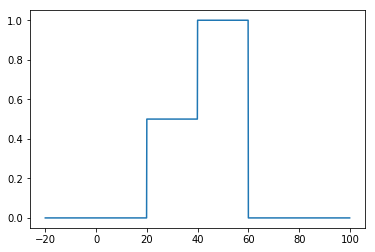

In [110]:
y3 = np.zeros(NT)
y3[400:600] =0.5
y3[600:800]=1
plt.figure()
plt.plot(EaxisT, y3)
plt.show()

In [111]:
import srins.powder.scaling as scaling
import random

# noisy (experimental) data creation with Gaussian Resolution

* when both resolution are good

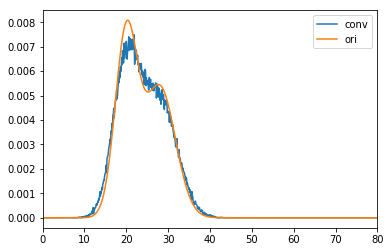

In [112]:
scaleY1=scaling.scale(np.dot(y1, res1), 0, 1000)
r = np.random.normal(size=y1.size)
nP1=np.sqrt(scaleY1) * r
g1= scaleY1+nP1
plt.figure()
plt.plot(EaxisT, g1/g1.sum(), label='conv')
plt.plot(EaxisT, y1/y1.sum(), label='ori')
# plt.plot(EaxisT, res1[400]/res1[400].sum(), label='res20')
# plt.plot(EaxisT, res1[500]/res1[500].sum(), label='res30')
plt.xlim(0,80)
plt.legend()
plt.show()

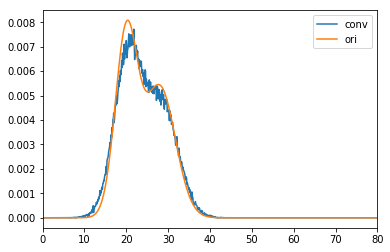

In [113]:
scaleY1N=scaling.scale(np.dot(y1, res2), 0, 1000)
# r = np.random.normal(size=y1.size)
nP1N=np.sqrt(scaleY1N) * r
g1N= scaleY1N+nP1N
plt.figure()
plt.plot(EaxisT, g1N/g1N.sum(), label='conv')
plt.plot(EaxisT, y1/y1.sum(), label='ori')
# plt.plot(EaxisT, res1[400]/res1[400].sum(), label='res20')
# plt.plot(EaxisT, res1[500]/res1[500].sum(), label='res30')
plt.xlim(0,80)
plt.legend()
plt.show()

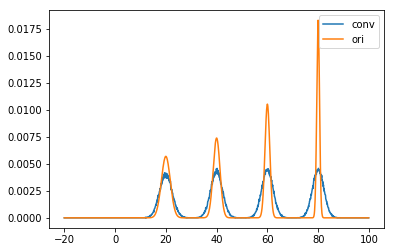

In [114]:
scaleY2=scaling.scale(np.dot(y2, res1), 0, 1000)
nP2=np.sqrt(scaleY2) * r
# nP2=0
g2= scaleY2+nP2
plt.figure()
plt.plot(EaxisT, g2/g2.sum(), label='conv')
plt.plot(EaxisT, y2/y2.sum(), label='ori')
# plt.plot(EaxisT, res1[400]/res1[400].sum(), label='res20')
# plt.plot(EaxisT, res1[650]/res1[650].sum(), label='res45')
# plt.xlim(0,80)
plt.legend()
plt.show()

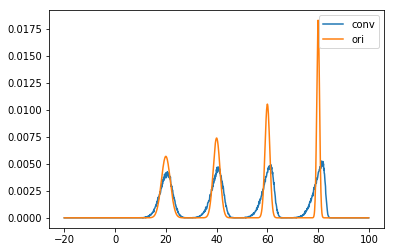

In [115]:
scaleY2N=scaling.scale(np.dot(y2, res2), 0, 1000)
nP2N=np.sqrt(scaleY2N) * r
# nP2N=0
g2N= scaleY2N+nP2N
plt.figure()
plt.plot(EaxisT, g2N/g2N.sum(), label='conv')
plt.plot(EaxisT, y2/y2.sum(), label='ori')
# plt.plot(EaxisT, res1[400]/res1[400].sum(), label='res20')
# plt.plot(EaxisT, res1[650]/res1[650].sum(), label='res45')
# plt.xlim(0,80)
plt.legend()
plt.show()

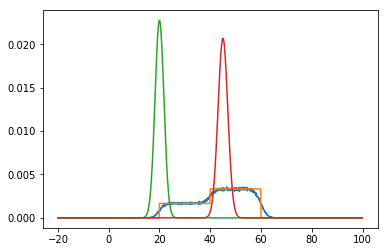

In [116]:
scaleY3=scaling.scale(np.dot(y3, res1), 0, 1000)
nP3=np.sqrt(scaleY3) * r
g3= scaleY3+nP3
plt.figure()
plt.plot(EaxisT, g3/g3.sum())
plt.plot(EaxisT, y3/y3.sum())
plt.plot(EaxisT, res1[400]/res1[400].sum(), label='res20')
plt.plot(EaxisT, res1[650]/res1[650].sum(), label='res45')
plt.show()

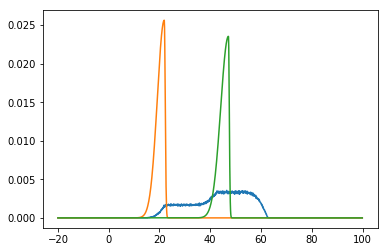

In [117]:
scaleY3N=scaling.scale(np.dot(y3, res2), 0, 1000)
nP3N=np.sqrt(scaleY3N) * r
g3N= scaleY3N+nP3N
plt.figure()
plt.plot(EaxisT, g3N/g3N.sum())
plt.plot(EaxisT, res2[400]/res2[400].sum(), label='res20')
plt.plot(EaxisT, res2[650]/res2[650].sum(), label='res45')
plt.show()

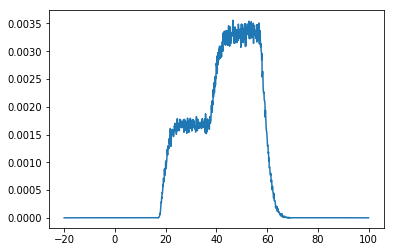

In [118]:
scaleY3NR=scaling.scale(np.dot(y3, res3), 0, 1000)
nP3NR=np.sqrt(scaleY3NR) * r
g3NR= scaleY3NR+nP3NR
plt.figure()
plt.plot(EaxisT, g3NR/g3NR.sum())
# plt.plot(EaxisT, res2[400]/res2[400].sum(), label='res20')
# plt.plot(EaxisT, res2[650]/res2[650].sum(), label='res45')
plt.show()

# Reconstruction

In [119]:
# reconstruction parameters for gaussian resolution, nonsymmetric resolution at right, non symmetric resolution at left

ini_uZ = np.zeros(NT)
ini_vZ = np.zeros(NT)

#for Gaussian resolution
RF_T = np.transpose(res1)
m = np.dot(RF_T, res1)
max_delta = 2. / LA.norm(m, ord=1)

#for non symmetric resolution at right
RF_T2 = np.transpose(res2)
m2 = np.dot(RF_T2, res2)
max_delta2 = 2. / LA.norm(m2, ord=1)

#for non symmetric resolution at left
RF_T3 = np.transpose(res3)
m3 = np.dot(RF_T3, res3)
max_delta3 = 2. / LA.norm(m3, ord=1)

In [120]:
delta=max_delta

delta2=max_delta2

delta3=max_delta3
print (delta)
print(delta2)
print(delta3)

1.7425202334904837
1.7153856373538492
1.66667274155773


In [121]:
# for case 1 with symmetric and non symmetric 

#for symmetric
neu_N1= np.linalg.norm(g1/g1.sum(), 2)**2 / 2/delta/np.linalg.norm(g1/g1.sum(),1)
print (neu_N1)
value1=np.sqrt(np.average(nP1**2))
print (value1)

# for non symmetric
neu_N1N= np.linalg.norm(g1N/g1N.sum(), 2)**2 / 2/delta2/np.linalg.norm(g1N/g1N.sum(),1)
# neu_N1N= np.linalg.norm(g1N, 2)**2 / 2/delta2/np.linalg.norm(g1N,1)

print (neu_N1N)
value1N=np.sqrt(np.average(nP1N**2))
print (value1N)




0.0014623447680450594
10.901530573696693
0.0014867611240635937
10.799385789818366


In [122]:
# for case 2 with symmetric and non symmetric 

# for symmetric
neu_N2= np.linalg.norm(g2/g2.sum(), 2)**2 / 2/delta/np.linalg.norm(g2/g2.sum(),1)
print (neu_N2)
value2=np.sqrt(np.average(nP2**2))
print (value2)

# for non symmetric
neu_N2N= np.linalg.norm(g2N/g2N.sum(), 2)**2 / 2/delta2/np.linalg.norm(g2N/g2N.sum(),1)
print (neu_N2N)
value2N=np.sqrt(np.average(nP2N**2))
print (value2N)

0.0008728907739926334
13.72958766804241
0.0009309941936048986
12.998729994872617


In [123]:
# for case 3 with symmetric and non symmetric (left and right)

# for symmetric
neu_N3= np.linalg.norm(g3/g3.sum(), 2)**2 / 2/delta/np.linalg.norm(g3/g3.sum(),1)
print (neu_N3)
value3=np.sqrt(np.average(nP3**2))
print (value3)

# for non symmetric (right)
neu_N3N= np.linalg.norm(g3N/g3N.sum(), 2)**2 / 2/delta2/np.linalg.norm(g3N/g3N.sum(),1)
print (neu_N3N)
value3N=np.sqrt(np.average(nP3N**2))
print (value3N)

# for non symmetric (left)
neu_N3NR= np.linalg.norm(g3NR/g3NR.sum(), 2)**2 / 2/delta3/np.linalg.norm(g3NR/g3NR.sum(),1)
print (neu_N3NR)
value3NR=np.sqrt(np.average(nP3NR**2))
print (value3NR)

0.0007442252995557635
16.190103739596513
0.0007570647219640132
16.15998047283525
0.0007796493558588353
16.223372862104977


In [124]:
maxit=500

# LINEARIZED BREGMAN Reconstruction

# CASE 1

## symmetric

In [125]:
%%time
for _ in range(1000):
    RV1, RU1, error1, it1, errorBL1 = splb.bregman_NS(g1, res1, ini_vZ, ini_uZ, neu_N1, delta, 'errorModel',value1, maxIter=maxit)

CPU times: user 2min 29s, sys: 2min 5s, total: 4min 34s
Wall time: 7.06 s


In [126]:
chi_LB=np.sum((y1-RU1)**2)/y1.shape[0]

In [127]:
print((chi_LB))

90720.39693153843


15


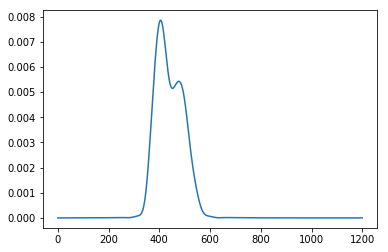

In [128]:
print (it1)

plt.figure()

plt.plot(RU1/RU1.sum())
# plt.plot(g1/g1.sum())
# plt.plot(y1/y1.sum())
plt.show()

## non symmetric

In [129]:
%%time
for _ in range(1000):
    RV1N, RU1N, error1N, it1N, errorBL1N = splb.bregman_NS(g1N, res2, ini_vZ, ini_uZ, neu_N1N, delta2, 'errorModel',value1N, maxIter=maxit)

CPU times: user 2min 5s, sys: 1min 55s, total: 4min 1s
Wall time: 6.27 s


In [130]:
chi_LBN=np.sum((y1-RU1N)**2)/y1.shape[0]

In [131]:
print (chi_LBN)

87452.5617461731


13


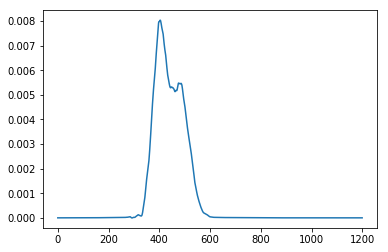

In [132]:
print (it1N)

plt.figure()
plt.plot(RU1N/RU1N.sum())
# plt.plot(RU1/RU1.sum())
# plt.plot(g1N/g1N.sum())
# plt.plot(y1/y1.sum())
plt.show()

# CASE 2

## symmetric

In [133]:
%%time
for _ in range(1000):
    RV2, RU2, error2, it2, errorBL2 = splb.bregman_NS(g2, res1, ini_vZ, ini_uZ, neu_N2, delta, 'errorModel',value2, maxIter=maxit)

CPU times: user 45min 9s, sys: 36min 31s, total: 1h 21min 40s
Wall time: 2min 4s


In [134]:
chi2_LB=np.sum((y2-RU2)**2)/y2.shape[0]

In [135]:
print (chi2_LB)

250939.56117804567


251


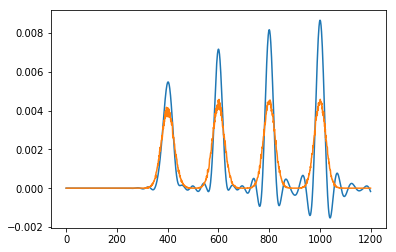

In [136]:
print (it2)

plt.figure()
plt.plot(RU2/RU2.sum())
plt.plot(g2/g2.sum())
plt.show()

## non-symmetric

In [137]:
%%time
for _ in range(1000):
    RV2N, RU2N, error2N, it2N, errorBL2N = splb.bregman_NS(g2N, res2, ini_vZ, ini_uZ, neu_N2N, delta2, 'errorModel',value2N, maxIter=100)

CPU times: user 12min 18s, sys: 10min 46s, total: 23min 5s
Wall time: 35.4 s


In [138]:
chi2_LB=np.sum((y1-RU1)**2)/y1.shape[0]

76


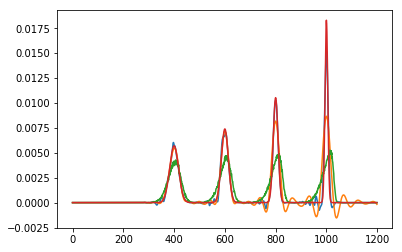

In [139]:
print (it2N)

plt.figure()
plt.plot(RU2N/RU2N.sum())
plt.plot(RU2/RU2.sum())
plt.plot(g2N/g2N.sum())
plt.plot(y2/y2.sum())
plt.show()

In [140]:
1/neu_N3

1343.6791259272043

# CASE 3

## symmetric

In [141]:
%%time
for _ in range(1000):
    RV3, RU3, error3, it3, errorBL3 = splb.bregman_NS(g3, res1, ini_vZ, ini_uZ, neu_N3, delta, 'errorModel',value3, maxIter=maxit)

CPU times: user 3min 4s, sys: 2min 18s, total: 5min 23s
Wall time: 8.15 s


19


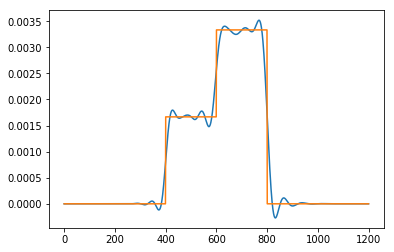

In [142]:
print(it3)

plt.figure()
plt.plot(RU3/RU3.sum())
# plt.plot(g3/g3.sum())
plt.plot(y3/y3.sum())
plt.show()

## non- symmetric right

In [143]:
%%time
for _ in range(1000):
    RV3N, RU3N, error3N, it3N, errorBL3N = splb.bregman_NS(g3N, res2, ini_vZ, ini_uZ, neu_N3N, delta2, 'errorModel',value3N, maxIter=500)

CPU times: user 2min 37s, sys: 2min 21s, total: 4min 58s
Wall time: 7.61 s


16


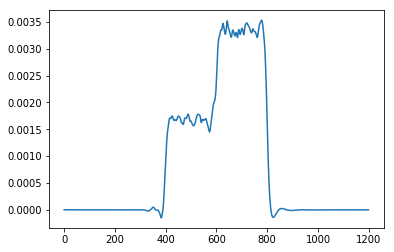

In [144]:
print (it3N)

plt.figure()
plt.plot(RU3N/RU3N.sum())
plt.show()

## non- symmetric left

15


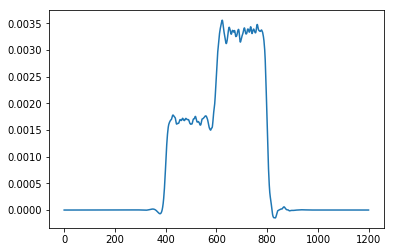

In [145]:
RV3NR, RU3NR, error3NR, it3NR, errorBL3NR = splb.bregman_NS(g3NR, res3, ini_vZ, ini_uZ, neu_N3NR, delta3, 'errorModel',value3NR, maxIter=500)

print (it3NR)

plt.figure()
# plt.plot(RU3N/RU3N.sum())
plt.plot(RU3NR/RU3NR.sum())
plt.show()

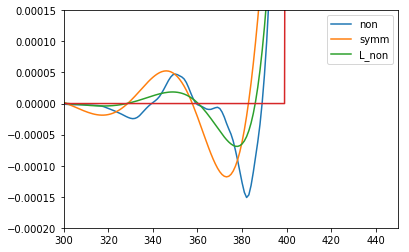

In [146]:
plt.figure()
plt.plot(RU3N/RU3N.sum(), label='non')
plt.plot(RU3/RU3.sum(), label='symm')
plt.plot(RU3NR/RU3NR.sum(), label='L_non')
# plt.plot(g3/g3.sum())
plt.plot(y3/y3.sum())
plt.ylim(-0.00020,0.00015)
plt.xlim(300,450)
# plt.xlim(780,1000)
plt.legend()
plt.show()

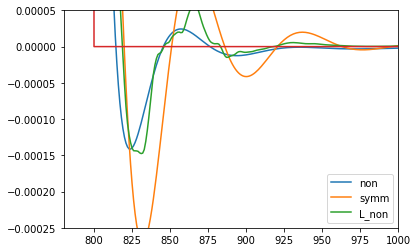

In [147]:
plt.figure()
plt.plot(RU3N/RU3N.sum(), label='non')
plt.plot(RU3/RU3.sum(), label='symm')
plt.plot(RU3NR/RU3NR.sum(), label='L_non')
# plt.plot(g3/g3.sum())
plt.plot(y3/y3.sum())
plt.ylim(-0.00025,0.00005)
# plt.xlim(300,450)
plt.xlim(780,1000)
plt.legend()
plt.show()

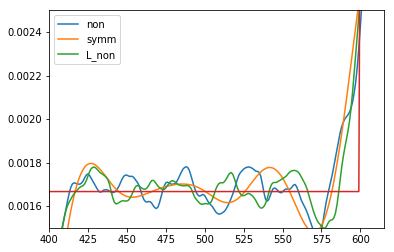

In [148]:
plt.figure()
plt.plot(RU3N/RU3N.sum(), label='non')
plt.plot(RU3/RU3.sum(), label='symm')
plt.plot(RU3NR/RU3NR.sum(), label='L_non')
# plt.plot(g3/g3.sum())
plt.plot(y3/y3.sum())
plt.ylim(0.0015,0.0025)
# plt.xlim(300,450)
plt.xlim(400,615)
plt.legend()
plt.show()

# SPLIT BREGMAN method

In [149]:
reload (spbs)

<module 'srins.powder.bregmanSplit' from '/home/fi0/dev/sandbox/SR-INS/1D/dev/srins/srins/powder/bregmanSplit.pyc'>

### SYMMETRIC 

In [150]:
#case 1

In [151]:
%%time
for _ in range(1000):
    recSplit1, itS1= spbs.split_Bregman(g1, res1, ini_vZ, ini_uZ, neu_N1, delta, value1, maxit)

CPU times: user 1min 56s, sys: 1min 31s, total: 3min 27s
Wall time: 5.39 s


In [152]:
chi1_SB=np.sum((y1-recSplit1)**2)/y1.shape[0]

In [153]:
print (chi1_SB)

89877.81630881519


S-B: 5 L-B: 15


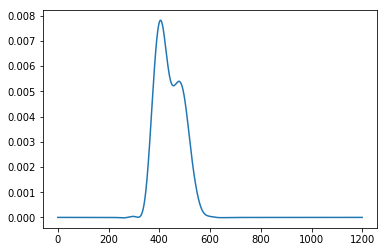

In [154]:
print ('S-B:',itS1, 'L-B:',it1)
plt.figure()
plt.plot(recSplit1/recSplit1.sum())

In [155]:
#case 2

In [156]:
%%time
for _ in range(1000):
    recSplit2, itS2= spbs.split_Bregman(g2, res1, ini_vZ, ini_uZ, neu_N2, delta, value2, maxit)

CPU times: user 1h 18min 20s, sys: 57min 15s, total: 2h 15min 36s
Wall time: 3min 26s


In [157]:
chi2_SB=np.sum((y2-recSplit2)**2)/y2.shape[0]

In [158]:
print (chi2_SB)

250929.34928867887


S-B: 215 L-B: 251


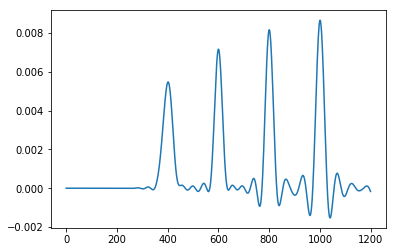

In [159]:
print ('S-B:',itS2, 'L-B:',it2)
plt.figure()
plt.plot(recSplit2/recSplit2.sum())

In [160]:
#case 3

In [161]:
%%time
for _ in range(1000):
    recSplit3, itS3= spbs.split_Bregman(g3, res1, ini_vZ, ini_uZ, neu_N3, delta, value3, maxit)

CPU times: user 5min 5s, sys: 3min 36s, total: 8min 42s
Wall time: 13.2 s


S-B: 14 L-B: 19


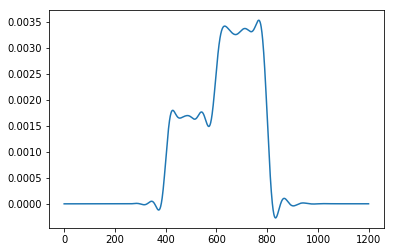

In [162]:
print ('S-B:',itS3, 'L-B:',it3)
plt.figure()
plt.plot(recSplit3/recSplit3.sum())

### NON-SYMMETRIC 

In [163]:
#case 1

In [164]:
%%time
for _ in range(1000):
    recSplit1N, itS1N= spbs.split_Bregman(g1N, res2, ini_vZ, ini_uZ, neu_N1N, delta2, value1N, maxit)

CPU times: user 1min 23s, sys: 1min 17s, total: 2min 41s
Wall time: 4.24 s


S-B: 4 L-B: 13


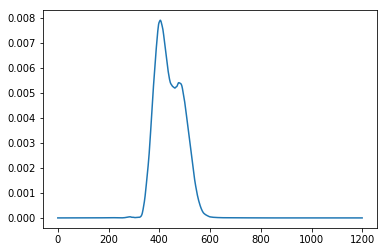

In [165]:
print ('S-B:', itS1N,'L-B:', it1N)
plt.figure()
plt.plot(recSplit1N/recSplit1N.sum())

In [166]:
#case 2

In [167]:
%%time
for _ in range(1000):
    recSplit2N, itS2N= spbs.split_Bregman(g2N, res2, ini_vZ, ini_uZ, neu_N2N, delta2, value2N, maxit)

CPU times: user 21min 20s, sys: 16min 38s, total: 37min 58s
Wall time: 57.7 s


S-B: 64 L-B: 76


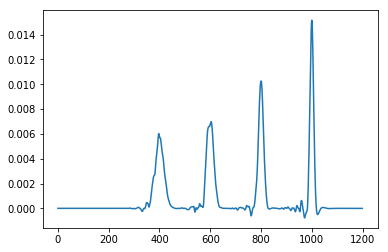

In [168]:
print ('S-B:', itS2N, 'L-B:', it2N)
plt.figure()
plt.plot(recSplit2N/recSplit2N.sum())

In [169]:
#case 3

In [170]:
%%time
for _ in range(1000):
    recSplit3N, itS3N= spbs.split_Bregman(g3N, res2, ini_vZ, ini_uZ, neu_N3N, delta2, value3N, maxit)

CPU times: user 4min 8s, sys: 3min 28s, total: 7min 37s
Wall time: 11.7 s


S-B: 12 L-B: 16


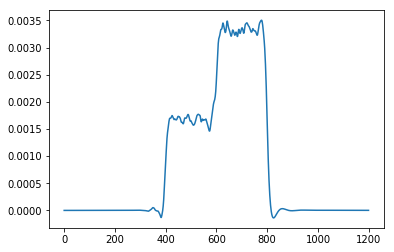

In [171]:
print ('S-B:',itS3N, 'L-B:',it3N)
plt.figure()
plt.plot(recSplit3N/recSplit3N.sum())

# LUCY-RICHARDSON method

### SYMMETRIC 

In [172]:
# case 1

In [173]:

ini1=(np.sum(g1,0)/len(g1)) * np.ones(len(g1))#initial guess

In [174]:
%%time
for _ in range(1000):
    R1,E1,EB1,In1=LR.deconvolve_NS(g1, res1, ini1, 'errorModel', value1,maxIter=maxit)

CPU times: user 1min 15s, sys: 52.9 s, total: 2min 8s
Wall time: 3.26 s


In [175]:
chi1_LR=np.sum((y1-R1)**2)/y1.shape[0]

In [176]:
print (chi1_LR)

89550.59811796506


LR: 7 L-B: 15 S-B: 5


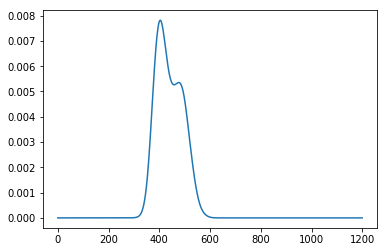

In [177]:
print ('LR:', In1,'L-B:',it1,'S-B:', itS1)
plt.figure()
plt.plot(R1/R1.sum())

In [178]:
#Case 2
ini2=(np.sum(g2,0)/len(g2)) * np.ones(len(g2))#initial guess

In [179]:
%%time
for _ in range(1000):
    R2,E2,EB2,In2=LR.deconvolve_NS(g2, res1, ini2, 'errorModel', value2,maxIter=maxit)

CPU times: user 20min 17s, sys: 14min 48s, total: 35min 5s
Wall time: 53 s


In [180]:
N=EaxisT.shape[0]
print (N)

1200


In [187]:
chi1_LR=np.sum((R1/np.sum(R1)-y1/np.sum(y1))**2)*N
chi1_LB=np.sum((RU1/np.sum(RU1)-y1/np.sum(y1))**2)*N
chi1_SB=np.sum(((recSplit1/np.sum(recSplit1))-(y1/np.sum(y1)))**2)*N

In [220]:
# chi1_LR=np.sum(np.abs(R1/np.sum(R1)-y1/np.sum(y1)))
# chi1_LB=np.sum(np.abs(RU1/np.sum(RU1)-y1/np.sum(y1)))
# chi1_SB=np.sum(np.abs(recSplit1/np.sum(recSplit1)-y1/np.sum(y1)))
# print (chi1_LR,chi1_LB, chi1_SB)

0.018820099258268542 0.01979597647753896 0.025827600739327525


In [219]:
# chi1_LR=np.sum(np.abs(R2/np.sum(R2)-y2/np.sum(y2)))
# chi1_LB=np.sum(np.abs(RU2/np.sum(RU2)-y2/np.sum(y2)))
# chi1_SB=np.sum(np.abs(recSplit2/np.sum(recSplit2)-y2/np.sum(y2)))
# print (chi1_LR,chi1_LB, chi1_SB)

0.07335369852411883 0.4652569854949573 0.4650362087130674


# New CHi_reduced Introduced

In [214]:
# N = len(y2)
# y_red = y2/np.sum(y2)
# print('sum of y_red = ', np.sum(y_red))
# y_red_mean = np.mean(y_red)
# print(y_red_mean)
# e_red_squared = y_red
# e_red_squared[e_red_squared<y_red_mean*1e-09] = 1.0
# R1_red =R2/np.sum(R2)
# print('sum of R1_red = ', np.sum(R1_red))
# chi2_red = np.sum((y_red - R1_red)**2 / e_red_squared)/N
# print(chi2_red)
#chi1_LR=np.sum( ((R1/np.sum(R1)-y1/np.sum(y1)) / (y1/np.sum(y1)) )**2)*N

sum of y_red =  1.0
0.0008333333333333334
sum of R1_red =  1.0
0.4893145112664239


In [216]:
print (chi1_LR,chi1_LB, chi1_SB)

2.863165948234866e-06 2.2839539575685415e-06 3.622282617235093e-06


In [272]:
chi2_LR=np.sum((R2/np.sum(R2)-y2/np.sum(y2))**2)*N
chi2_LB=np.sum((RU2/np.sum(RU2)-y2/np.sum(y2))**2)*N
chi2_SB=np.sum(((recSplit2/np.sum(recSplit2))-(y2/np.sum(y2)))**2)*N

In [273]:
print (chi2_LR,chi2_LB, chi2_SB)

0.0739897806856 1.37951817243 1.37880970523


In [274]:
chi3_LR=np.sum((R3/np.sum(R3)-y3/np.sum(y3))**2)*N
chi3_LB=np.sum((RU3/np.sum(RU3)-y3/np.sum(y3))**2)*N
chi3_SB=np.sum(((recSplit3/np.sum(recSplit3))-(y3/np.sum(y3)))**2)*N

In [275]:
print (chi3_LR,chi3_LB, chi3_SB)

0.041038008595 0.0600841332892 0.0607109389061


In [278]:
chi1N_LR=np.sum((R1N/np.sum(R1N)-y1/np.sum(y1))**2)*N
chi1N_LB=np.sum((RU1N/np.sum(RU1N)-y1/np.sum(y1))**2)*N
chi1N_SB=np.sum(((recSplit1N/np.sum(recSplit1N))-(y1/np.sum(y1)))**2)*N

In [279]:
print (chi1N_LR,chi1N_LB, chi1N_SB)

0.0018163974721 0.0036406552805 0.00291663411317


In [280]:
chi2N_LR=np.sum((R2N/np.sum(R2N)-y2/np.sum(y2))**2)*N
chi2N_LB=np.sum((RU2N/np.sum(RU2N)-y2/np.sum(y2))**2)*N
chi2N_SB=np.sum(((recSplit2N/np.sum(recSplit2N))-(y2/np.sum(y2)))**2)*N

In [281]:
print (chi2N_LR,chi2N_LB, chi2N_SB)

0.0404071092761 0.196097263081 0.195074999353


In [282]:
chi3N_LR=np.sum((R3N/np.sum(R3N)-y3/np.sum(y3))**2)*N
chi3N_LB=np.sum((RU3N/np.sum(RU3N)-y3/np.sum(y3))**2)*N
chi3N_SB=np.sum(((recSplit3N/np.sum(recSplit3N))-(y3/np.sum(y3)))**2)*N

In [283]:
print (chi3N_LR,chi3N_LB, chi3N_SB)

0.0267998506912 0.0350863531917 0.0348309054273


LR: 187 L-B: 395 S-B: 339


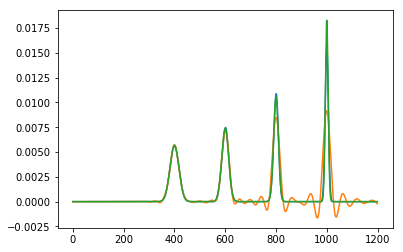

In [142]:
print ('LR:',In2,'L-B:',it2,'S-B:', itS2 )
plt.figure()
plt.plot(R2/R2.sum())
plt.plot(RU2/RU2.sum())
plt.plot(y2/y2.sum())

In [ ]:
#Case 3
ini3=(np.sum(g3,0)/len(g3)) * np.ones(len(g3))#initial guess

In [253]:
%%time
for _ in range(1000):
    R3,E3,EB3,In3=LR.deconvolve_NS(g3, res1, ini3, 'errorModel', value3,maxIter=maxit)

CPU times: user 6min 14s, sys: 8.86 s, total: 6min 22s
Wall time: 19.1 s


In [156]:
print ('LR:',In3, 'L-B:',it3,'S-B:', itS3)
plt.figure()
plt.plot(R3/R3.sum())

NameError: name 'it3' is not defined

### NON-SYMMETRIC 

In [254]:
# CASE 1
ini1N=(np.sum(g1N,0)/len(g1N)) * np.ones(len(g1N))#initial guess

In [255]:
%%time
for _ in range(1000):
    R1N,E1N,EB1N,In1N=LR.deconvolve_NS(g1N, res2, ini1N, 'errorModel', value1N,maxIter=maxit)

CPU times: user 39 s, sys: 973 ms, total: 40 s
Wall time: 2 s


LR: 7 L-B: 13 S-B: 4


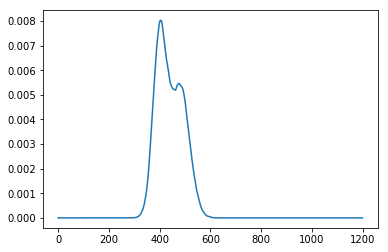

In [152]:
print ('LR:', In1N,'L-B:',it1N,'S-B:', itS1N)
plt.figure()
plt.plot(R1N/R1N.sum())

In [256]:
#CASE 2
ini2N=(np.sum(g2N,0)/len(g2N)) * np.ones(len(g2N))#initial guess

In [257]:
%%time
for _ in range(1000):
    R2N,E2N,EB2N,In2N=LR.deconvolve_NS(g2N, res2, ini2N, 'errorModel', value2N,maxIter=maxit)

CPU times: user 6min 7s, sys: 10.5 s, total: 6min 17s
Wall time: 18.9 s


LR: 48 L-B: 82 S-B: 69


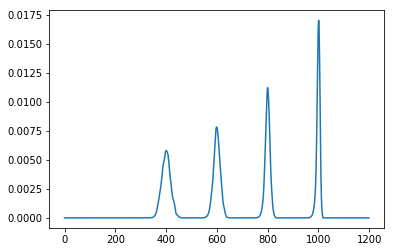

In [153]:
print ('LR:', In2N,'L-B:',it2N,'S-B:', itS2N)
plt.figure()
plt.plot(R2N/R2N.sum())

In [259]:
#CASE 3
ini3N=(np.sum(g3N,0)/len(g3N)) * np.ones(len(g3N))#initial guess

In [260]:
%%time
for _ in range(1000):
    R3N,E3N,EB3N,In3N=LR.deconvolve_NS(g3N, res2, ini3N, 'errorModel', value3N, maxIter=maxit)

/home/fi0/dev/sandbox/SR-INS/1D/dev/srins/srins/powder/Lucy_Richardson.py:53: RuntimeWarning: invalid value encountered in divide
  relative_blur = sig / sigC


CPU times: user 1min 52s, sys: 3.14 s, total: 1min 56s
Wall time: 5.8 s


LR: 27 L-B: 18 S-B: 16


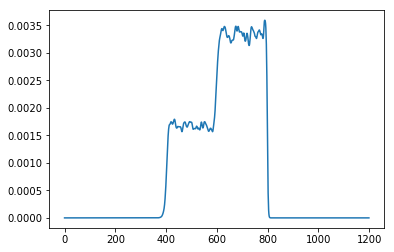

In [154]:
print ('LR:', In3N,'L-B:',it3N,'S-B:', itS3N)
plt.figure()
plt.plot(R3N/R3N.sum())

# CASE 1 (SYMMETRIC) with ALL METHODS

<IPython.core.display.Javascript object>


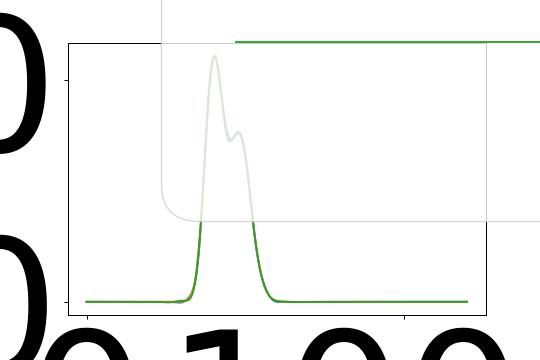

In [155]:
%matplotlib notebook
plt.figure('CASE 1 (SYMMETRIC)' )
plt.plot(RU1, label='L bregman({})'.format(it1))
plt.plot(R1, label='Lucy({})'.format(In1))
plt.plot(recSplit1, label='Split({})'.format(itS1))
plt.legend()
plt.show()

# CASE 2 (SYMMETRIC) with ALL METHODS

<IPython.core.display.Javascript object>


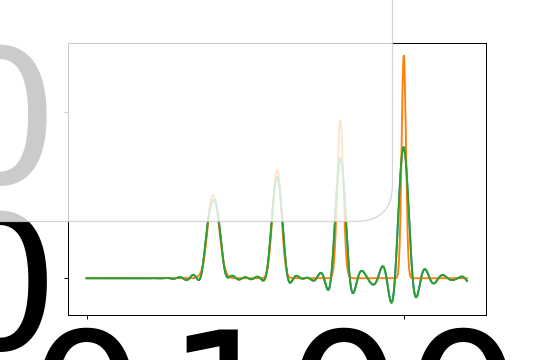

In [156]:
%matplotlib notebook
plt.figure('CASE 2 (SYMMETRIC)')
plt.plot(RU2, label='L bregman({})'.format(it2))
plt.plot(R2, label='Lucy({})'.format(In2))
plt.plot(recSplit2, label='Split({})'.format(itS2))
plt.legend()
plt.show()

# CASE 3 (SYMMETRIC) with ALL METHODS

<IPython.core.display.Javascript object>


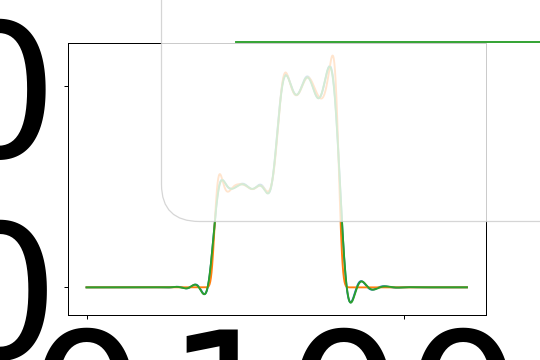

In [157]:
%matplotlib notebook
plt.figure()
plt.plot(RU3, label='L bregman({})'.format(it3))
plt.plot(R3, label='Lucy({})'.format(In3))
plt.plot(recSplit3, label='Split({})'.format(itS3))
plt.legend()
plt.show()

# CASE 1 (NON-SYMMETRIC) with ALL METHODS

<IPython.core.display.Javascript object>


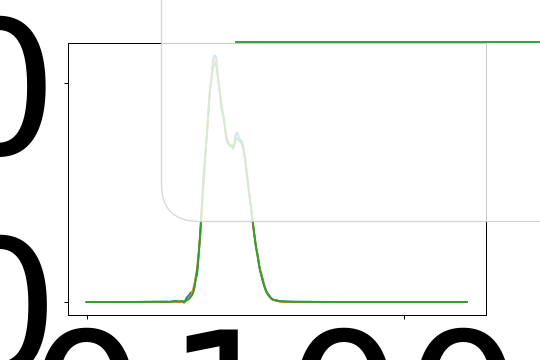

In [158]:
%matplotlib notebook
plt.figure('CASE 1 (NON-SYMMETRIC)' )
plt.plot(RU1N, label='L bregman({})'.format(it1N))
plt.plot(R1N, label='Lucy({})'.format(In1N))
plt.plot(recSplit1N, label='Split({})'.format(itS1N))
plt.legend()
plt.show()

# CASE 2 (NON-SYMMETRIC) with ALL METHODS

<IPython.core.display.Javascript object>


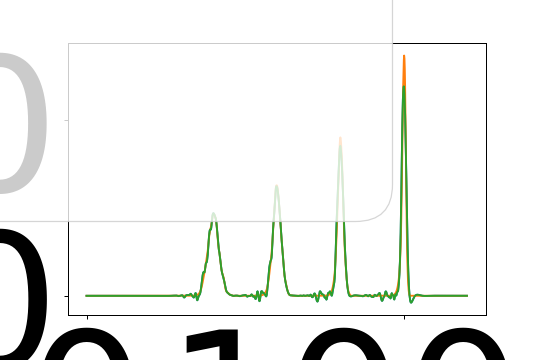

In [159]:
%matplotlib notebook
plt.figure('CASE 2 (NON-SYMMETRIC)' )
plt.plot(RU2N, label='L bregman({})'.format(it2N))
plt.plot(R2N, label='Lucy({})'.format(In2N))
plt.plot(recSplit2N, label='Split({})'.format(itS2N))
plt.legend()
plt.show()

In [160]:
# CASE 3 (NON-SYMMETRIC) with ALL METHODS

<IPython.core.display.Javascript object>


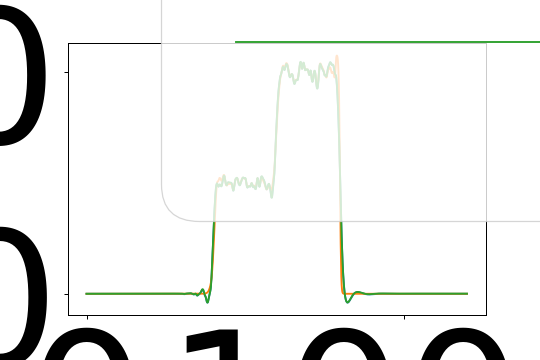

In [161]:
%matplotlib notebook
plt.figure('CASE 3 (NON-SYMMETRIC)' )
plt.plot(RU3N, label='L bregman({})'.format(it3N))
plt.plot(R3N, label='Lucy({})'.format(In3N))
plt.plot(recSplit3N, label='Split({})'.format(itS3N))
plt.legend()
plt.show()

In [162]:
# %matplotlib notebook
# plt.figure(figsize=(10,18))
# # plt.plot(RU2, label='L bregman')
# plt.plot(EaxisT, R2/R2.sum(), label='Lucy Sys R')
# plt.plot(EaxisT,R2N/R2N.sum(), label='Lucy Nons R')
# plt.plot(EaxisT,y2/y2.sum(), label='ori')
# plt.plot(EaxisT,g2/g2.sum(), label='noisy broaden')
# plt.xlim(12,85)

# # plt.plot(recSplit2, label='Split')
# plt.legend()
# plt.show()

In [163]:
plt.figure(figsize=(120,100))
s=150
plt.rc('font', size=s)
plt.subplot(3,3,1)
plt.rc('font', size=s)
plt.plot(EaxisT, y1/y1.sum())
plt.text(3, 0.0064, '(a)', fontsize=s)
plt.ylabel('Intensity (arb. units)',fontsize=s,family='serif' )
plt.xticks([])
plt.ticklabel_format(axis='y', style='sci', scilimits=(10,10), size=s,family='serif')
plt.yticks(size=s)
plt.xlim(0,50)
plt.subplot(3,3,2)
plt.plot(EaxisT, y2/y2.sum())
plt.text(5, 0.015, '(b)', fontsize=s)
plt.yticks([])
plt.xticks([])
plt.xlim(0,90)
plt.subplot(3,3,3)
plt.plot(EaxisT, y3/y3.sum())
plt.text(5, 0.0028, '(c)', fontsize=s)
plt.yticks([])
plt.xticks([])
plt.xlim(0,80)
plt.subplot(3,3,4)
plt.plot(EaxisT, g1/g1.sum())
plt.text(3, 0.0064, '(d)', fontsize=s)
plt.ylabel('Intensity (arb. units)',fontsize=s,family='serif')
plt.yticks(fontsize=s)
plt.ticklabel_format(axis='y', style='sci', scilimits=(10,10), size=s,family='serif')
plt.xticks([])
plt.xlim(0,50)
plt.subplot(3,3,5)
plt.plot(EaxisT, g2/g2.sum())
plt.text(5, 0.004, '(e)', fontsize=s)
plt.yticks([])
plt.xticks([])
plt.xlim(0,90)
plt.subplot(3,3,6)
plt.plot(EaxisT, g3/g3.sum())
plt.text(5, 0.0028, '(f)', fontsize=s)
plt.yticks([])
plt.xticks([])
plt.xlim(0,80)
plt.subplot(3,3,7)
plt.plot(EaxisT, RU1/RU1.sum(), label='Linearized Bregman')
plt.text(3, 0.008, '(g)', fontsize=s)
plt.plot(EaxisT, recSplit1/recSplit1.sum()+0.001, label='Split Bregman')
plt.plot(EaxisT, R1/R1.sum()+0.002, label='Lucy-Richardson')
plt.legend( fontsize='x-small',bbox_to_anchor=(0.51, 0.75))
plt.xlabel('E(meV)', fontsize=s,family='serif')
plt.ylabel('Intensity (arb. units)',fontsize=s,family='serif')
plt.yticks(fontsize=s)
plt.xticks(fontsize=s)
plt.ticklabel_format(axis='y', style='sci', scilimits=(10,10), labelsize=s,family='serif')
plt.xlim(0,50)
plt.subplot(3,3,8)
plt.plot(EaxisT, RU2/RU2.sum())
plt.plot(EaxisT, recSplit2/recSplit2.sum()+0.001)
plt.plot(EaxisT, R2/R2.sum()+0.002)
plt.text(5, 0.014, '(h)', fontsize=s)
plt.xlabel('E(meV)', fontsize=s,family='serif')
plt.xticks(fontsize=s, family='serif')
plt.yticks([])
plt.xlim(0,90)
plt.subplot(3,3,9)
plt.plot(EaxisT, RU3/RU3.sum())
plt.plot(EaxisT, recSplit3/recSplit3.sum()+0.001)
plt.plot(EaxisT, R3/R3.sum()+0.002)
plt.text(5, 0.005, '(i)', fontsize=s)
plt.xlabel('E(meV)', fontsize=s, family='serif')
plt.xticks(fontsize=s, family='serif')
plt.yticks([])
plt.xlim(0,80)
plt.savefig('symmetric_Resolution_Test2.eps',  dpi=1000)

<IPython.core.display.Javascript object>

In [164]:
plt.figure(figsize=(120,100))
plt.rc('font', size=s)
plt.subplot(3,3,1)
plt.plot(EaxisT, y1/y1.sum())
plt.ylabel('Intensity (arb. units)',fontsize=s, family='serif')
plt.text(3, 0.0064, '(a)', fontsize=s)
plt.yticks(fontsize=s,family='serif')
plt.xticks(fontsize=s)
plt.xticks([])
plt.xlim(0,50)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0), size=s)
plt.subplot(3,3,2)
plt.plot(EaxisT, y2/y2.sum())
plt.text(5, 0.015, '(b)', fontsize=s)
plt.yticks(fontsize=s)
plt.xticks(fontsize=s)
plt.xticks([])
plt.yticks([])
plt.xlim(0,90)
plt.subplot(3,3,3)
plt.plot(EaxisT, y3/y3.sum())
plt.text(5, 0.0028, '(c)', fontsize=s)
plt.yticks(fontsize=s)
plt.xticks(fontsize=s)
plt.xticks([])
plt.yticks([])
plt.xlim(0,80)
plt.subplot(3,3,4)
plt.plot(EaxisT, g1N/g1N.sum())
plt.text(3, 0.0064, '(d)', fontsize=s)
plt.ylabel('Intensity (arb. units)',fontsize=s,family='serif')
plt.yticks(fontsize=s, family='serif')
plt.xticks(fontsize=s)
plt.xticks([])
plt.xlim(0,50)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0), size=s)
plt.subplot(3,3,5)
plt.plot(EaxisT, g2N/g2N.sum())
plt.text(5, 0.004, '(e)', fontsize=s)
plt.yticks(fontsize=s)
plt.xticks(fontsize=s)
plt.xticks([])
plt.yticks([])
plt.xlim(0,90)
plt.subplot(3,3,6)
plt.plot(EaxisT, g3N/g3N.sum())
plt.text(5, 0.0028, '(f)', fontsize=s)
plt.yticks(fontsize=s)
plt.xticks(fontsize=s)
plt.xticks([])
plt.yticks([])
plt.xlim(0,80)
plt.subplot(3,3,7)
plt.plot(EaxisT, RU1N/RU1N.sum(), label='Linearized Bregman')
plt.plot(EaxisT, recSplit1N/recSplit1N.sum()+0.001, label='Split Bregman')
plt.plot(EaxisT, R1N/R1N.sum()+0.002, label='Lucy-Richardson')
plt.legend( fontsize='x-small',bbox_to_anchor=(0.51, 0.75))
plt.text(3, 0.008, '(g)', fontsize=s)
plt.xlabel('E(meV)', fontsize=s,family='serif')
plt.xlim(0,50)
plt.xticks(fontsize=s,family='serif')
plt.yticks(fontsize=s)
plt.ylabel('Intensity (arb. units)',fontsize=s,family='serif')
plt.yticks(fontsize=s,family='serif')
plt.xticks(fontsize=s,family='serif')
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0), size=s)
plt.subplot(3,3,8)
plt.plot(EaxisT, RU2N/RU2N.sum())
plt.plot(EaxisT, recSplit2N/recSplit2N.sum()+0.001)
plt.plot(EaxisT, R2N/ R2N.sum()+0.002)
plt.text(5, 0.016, '(h)', fontsize=s)
plt.xlabel('E(meV)', fontsize=s,family='serif')
plt.xticks(fontsize=s,family='serif')
plt.yticks(fontsize=s)
plt.xlim(0,90)
plt.yticks([])
plt.subplot(3,3,9)
plt.plot(EaxisT, RU3N/RU3N.sum())
plt.plot(EaxisT, recSplit3N/recSplit3N.sum()+0.001)
plt.plot(EaxisT, R3N/R3N.sum()+0.002)
plt.text(5, 0.0045, '(i)', fontsize=s)
plt.xlabel('E(meV)',family='serif', fontsize=s) #,style='italic'
plt.xticks(fontsize=s,family='serif')
plt.xlim(0,80)
# plt.yticks(fontsize=18)
# plt.xticks([])
plt.yticks([])
plt.savefig('NoNsymmetric_Resolution_Test1.eps',  dpi=1000)

<IPython.core.display.Javascript object>